In [1]:
import os
os.chdir('C:/Users/ASUS/Desktop/Data Science/portfolio projects/Time Series Analysis')

In [2]:
import pandas as pd
import numpy as np
train_data=pd.read_csv('C:/Users/ASUS/Desktop/Data Science/portfolio projects/Time Series Analysis/Data/Train Data.csv')
test_data=pd.read_csv('C:/Users/ASUS/Desktop/Data Science/portfolio projects/Time Series Analysis/Data/Test Data.csv')

In [3]:
import matplotlib.pyplot as plt
import matplotlib.pylab as py
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 30,12

In [5]:
from math import floor
#split the train data into training set and valid set
train = train_data.loc[:floor(2*train_data.shape[0]/3)]
valid = train_data.loc[floor(2*train_data.shape[0]/3):]
train.set_index('Datetime', inplace = True)
valid.set_index('Datetime', inplace = True)
test_data.set_index('Datetime', inplace = True)

In [6]:
print (train.shape)
print (valid.shape)
train.head()

(12193, 2)
(6096, 2)


,ID,Count
Datetime,,
25-08-2012 00:00,0,8
25-08-2012 01:00,1,2
25-08-2012 02:00,2,6
25-08-2012 03:00,3,2
25-08-2012 04:00,4,2


In [12]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5112 entries, 26-09-2014 00:00 to 26-04-2015 23:00
Data columns (total 1 columns):
ID    5112 non-null int64
dtypes: int64(1)
memory usage: 79.9+ KB


In [13]:
#parsing the datetime data 
dataparse = lambda dates: pd.datetime.strptime(dates, "%d-%m-%Y %H:%M")

train.index = train.index.map(dataparse)
valid.index = valid.index.map(dataparse)

test_data.index = test_data.index.map(dataparse)
train.head()

,ID,Count
Datetime,,
2012-08-25 00:00:00,0,8
2012-08-25 01:00:00,1,2
2012-08-25 02:00:00,2,6
2012-08-25 03:00:00,3,2
2012-08-25 04:00:00,4,2


# Stationarity checking
Stationary: if its statistical properties such as mean, variance remain constant over time. Intuitively, if a TS has a particular behaviour over time , there is a high probability that it will follow the same in future. Criteria for stationary series:

* Constant mean
* Constant variable
* Autocovariance that does not depend on time

In [43]:

from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=24).mean() # 24 hours on each day
    rolstd = timeseries.rolling(window=24).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

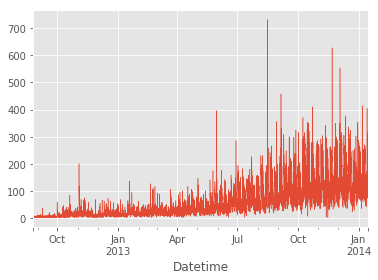

In [19]:
plt.style.use('ggplot')
train.Count.plot(linewidth=0.5)

In [20]:
import matplotlib.dates as mdates

train['Year'] = train.index.year
train['Month'] = train.index.month
train['Weekday Name'] = train.index.weekday_name
train.head()

C:\Users\ASUS\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\ASUS\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\Users\ASUS\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = v

,ID,Count,Year,Month,Weekday Name
Datetime,,,,,
2012-08-25 00:00:00,0,8,2012,8,Saturday
2012-08-25 01:00:00,1,2,2012,8,Saturday
2012-08-25 02:00:00,2,6,2012,8,Saturday
2012-08-25 03:00:00,3,2,2012,8,Saturday
2012-08-25 04:00:00,4,2,2012,8,Saturday


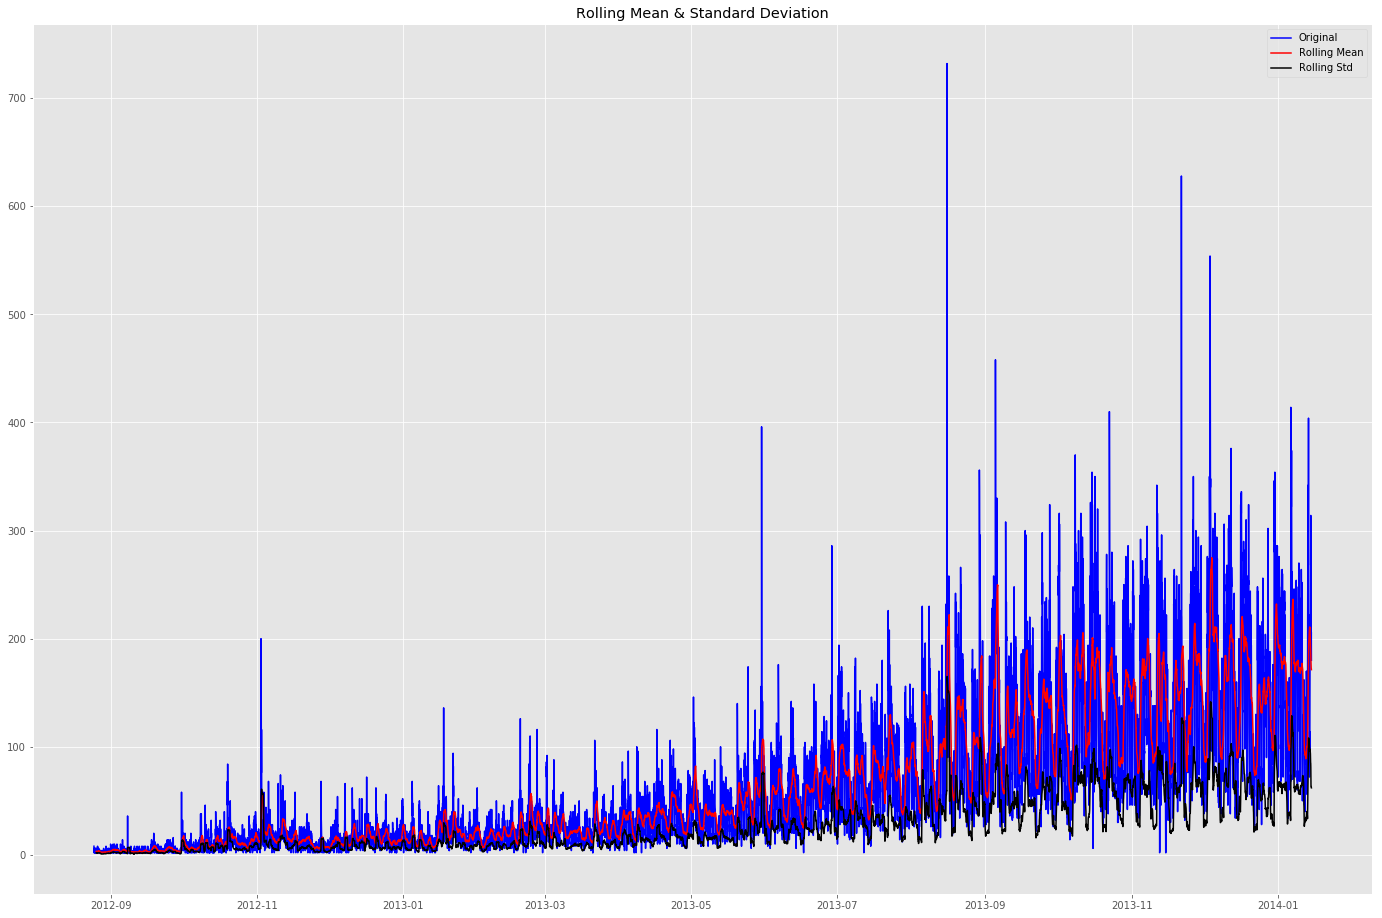

Results of Dickey-Fuller Test:
Test Statistic                -5.870107e+00
p-value                        3.255333e-07
#Lags Used                     4.000000e+01
Number of Observations Used    1.215200e+04
Critical Value (1%)           -3.430888e+00
Critical Value (5%)           -2.861778e+00
Critical Value (10%)          -2.566897e+00
dtype: float64


In [46]:
plt.figure(figsize=(24,16))
test_stationarity(train['Count'])

Evethough the Statistic Test show that the data is stationary ( Test Statistic < Critical Values), we still can see an increasing trend in the data. Therefore, we will try to make the data more stationary firstly. We need to remove two properties from the data: trend and seasonality.

# Trend removing
Trend: data varying mean over time. For example: the number of the value can increase or decrease over time. Estimating and Eliminating Trend techniques: Transformation: for example, for increasing trend, we can apply transformation which penalizes higher values more than smaller ones. For example: log, square roor,... Some ways to estimate and remove the trend:

* Aggregation: taking average of time period lik monthly/weekly
* Smoothing: taking rolling average
* Polynomial fitting: fit a regression model


## Smoothing

Computing the rolling average of the data. Here we take the window size in 24 based on the fact that each day has 24 hours

In [47]:
train_log = np.log(train['Count'])

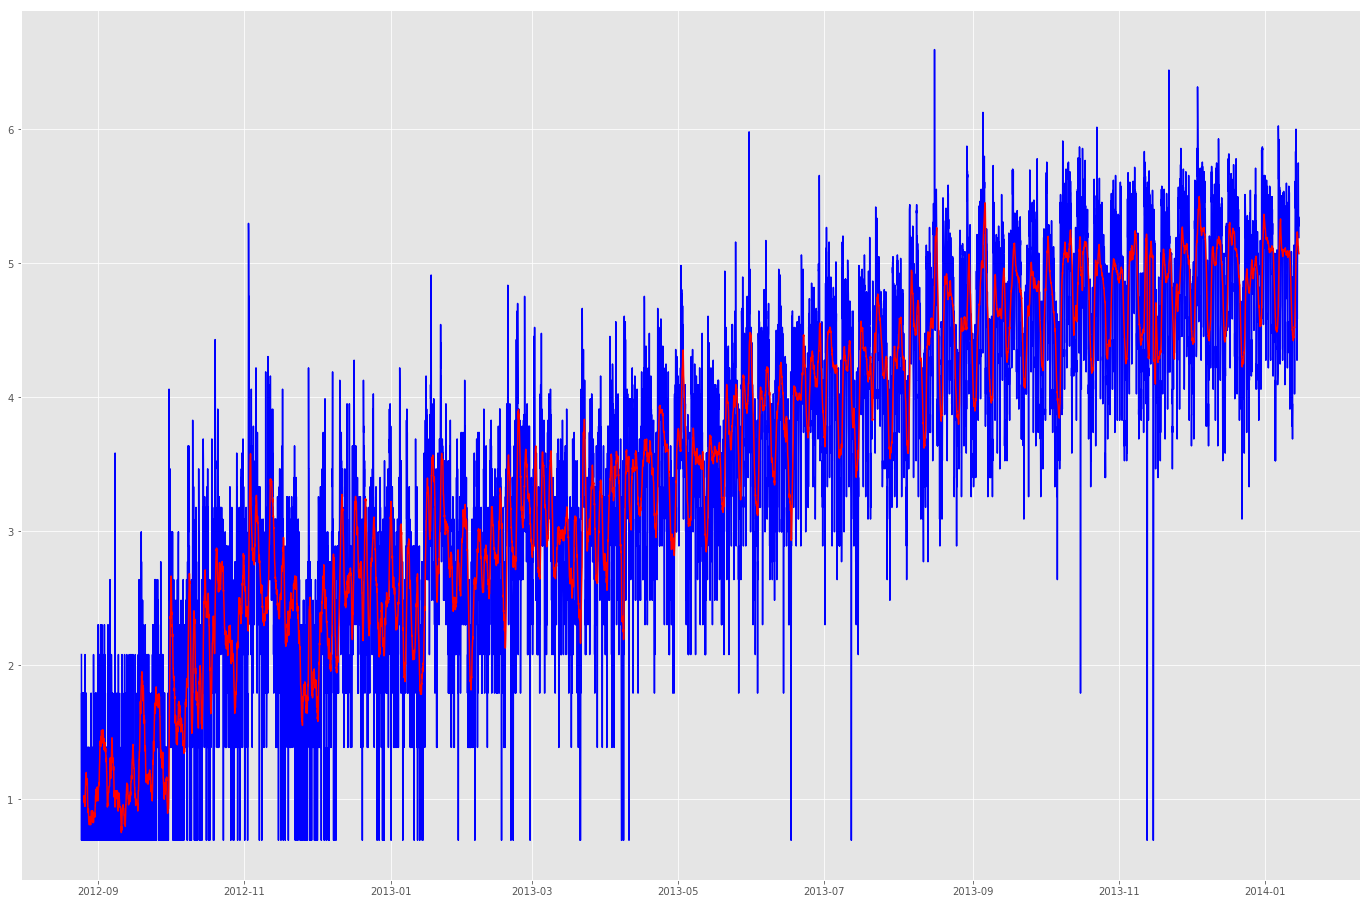

In [52]:
plt.figure(figsize=(24,16))
moving_avg = train_log.rolling(window= 24).mean()
plt.plot(train_log,color='blue')
plt.plot(moving_avg, color = 'red')

In [53]:
#removing the increasing trend 
train_log_moving_avg_diff = train_log - moving_avg

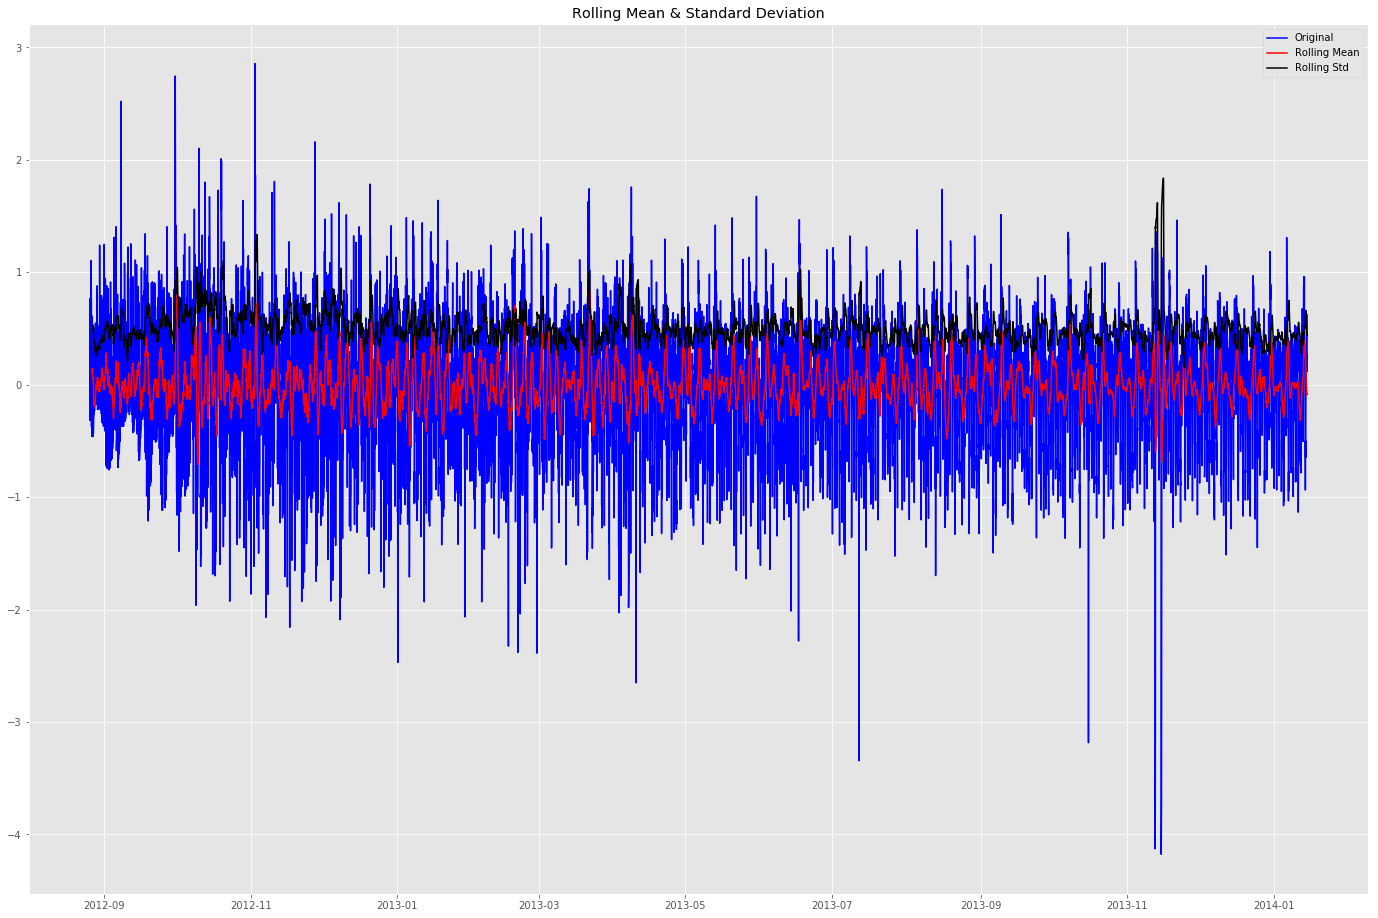

Results of Dickey-Fuller Test:
Test Statistic                   -22.510569
p-value                            0.000000
#Lags Used                        40.000000
Number of Observations Used    12129.000000
Critical Value (1%)               -3.430889
Critical Value (5%)               -2.861778
Critical Value (10%)              -2.566897
dtype: float64


In [56]:
plt.figure(figsize=(24,16))
# Since we are taking the average of 24 values, rolling mean is not defined for the first 23 values. (NaN)
train_log_moving_avg_diff.dropna(inplace = True)
test_stationarity(train_log_moving_avg_diff)

The Test Statistic values is way smaller than the critical value so we can be confident that the data is stationary now. A disadvantage of smoothing: the time period must strictly predicted. For example, in case of stock price, it may not be easy to come up with a time frame.

# Exponentially weighted moving average

EWMA is another popular technique where weights are assigned to all the previous values with a decay factor. Find details in here http://pandas.pydata.org/pandas-docs/stable/computation.html#exponentially-weighted-moment-functions

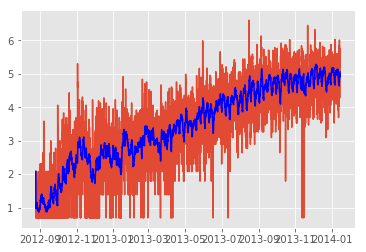

In [63]:
expwighted_avg = train_log.ewm(halflife=24).mean()
plt.plot(train_log)
plt.plot(expwighted_avg, color='blue')

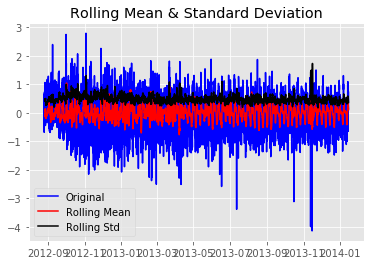

Results of Dickey-Fuller Test:
Test Statistic                   -20.177390
p-value                            0.000000
#Lags Used                        40.000000
Number of Observations Used    12152.000000
Critical Value (1%)               -3.430888
Critical Value (5%)               -2.861778
Critical Value (10%)              -2.566897
dtype: float64


In [64]:
#removing the trend of increasing
train_log_ewma_diff = train_log - expwighted_avg
test_stationarity(train_log_ewma_diff)

# Seasonality remove
Seasonality: variations at specific time-frames. E.g: people have tendency to buy jacket in winters To remove the seasonality, we have two techniques:

* Differencing: taking the difference with a particular time lag
* Decomposition: modeling both trend and seasonality and removing them from the model

## Differencing
Usually, non-stationary series can be corrected by just differencing.The idea behind differencing is that, if the original data series does not have constant properties over time, then the change from one period to another might.

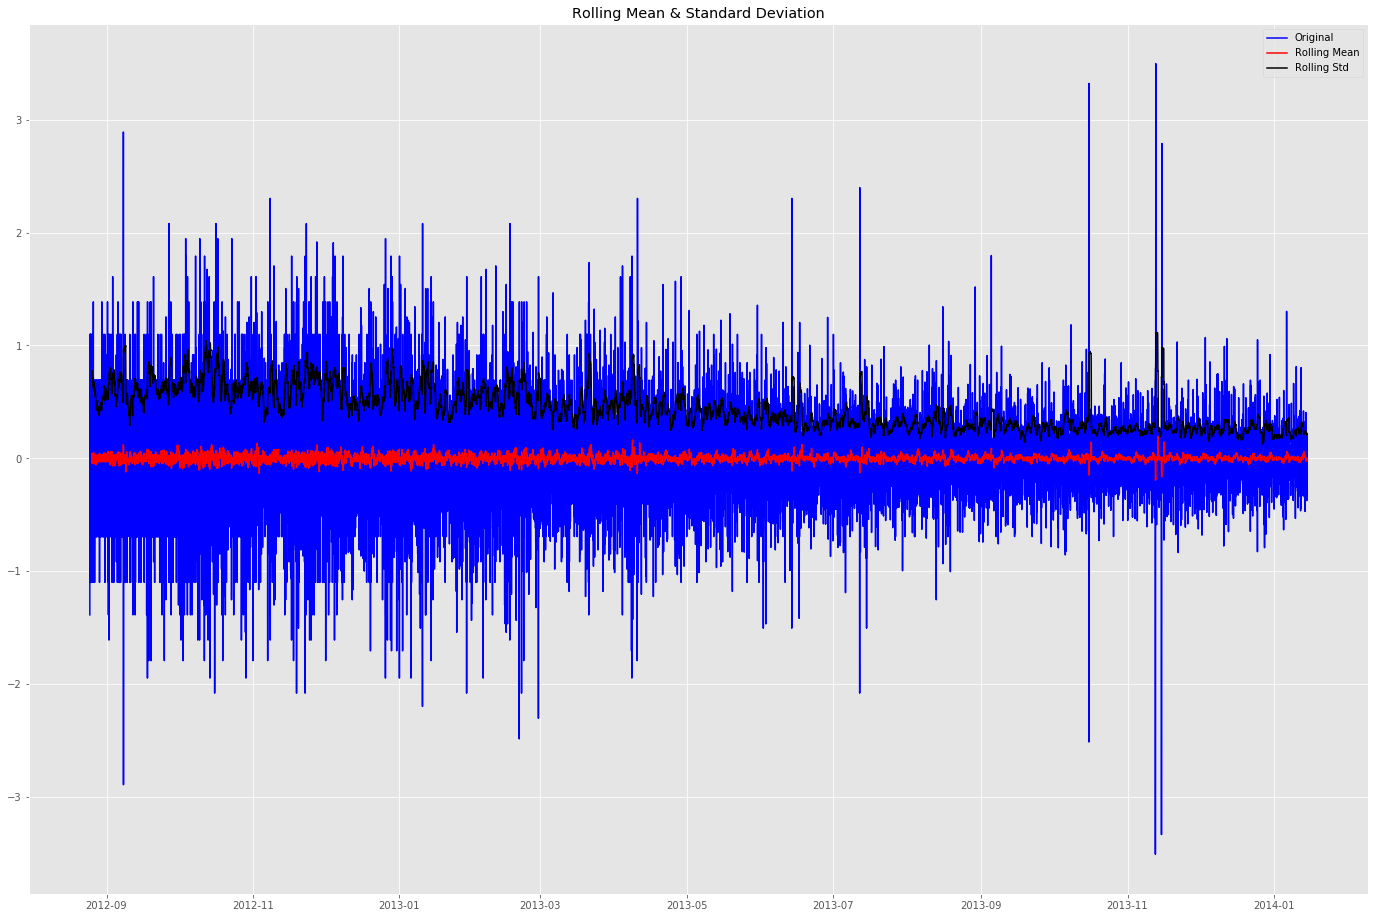

Results of Dickey-Fuller Test:
Test Statistic                   -21.889631
p-value                            0.000000
#Lags Used                        40.000000
Number of Observations Used    12151.000000
Critical Value (1%)               -3.430888
Critical Value (5%)               -2.861778
Critical Value (10%)              -2.566897
dtype: float64


In [67]:
plt.figure(figsize=(24,16))
train_log_diff = train_log - train_log.shift()
test_stationarity(train_log_diff.dropna())

In [66]:
train_log_diff.head()

Datetime
2012-08-25 00:00:00         NaN
2012-08-25 01:00:00   -1.386294
2012-08-25 02:00:00    1.098612
2012-08-25 03:00:00   -1.098612
2012-08-25 04:00:00    0.000000
Name: Count, dtype: float64

## Decomposition

In decomposition, trend and seasonality are treated separatedly. Let's recall the definitions:

* Trend: The increasing or decreasing value in the series.
* Seasonality: The repeating short-term cycle in the series.
* Residual: The random variation in the series.

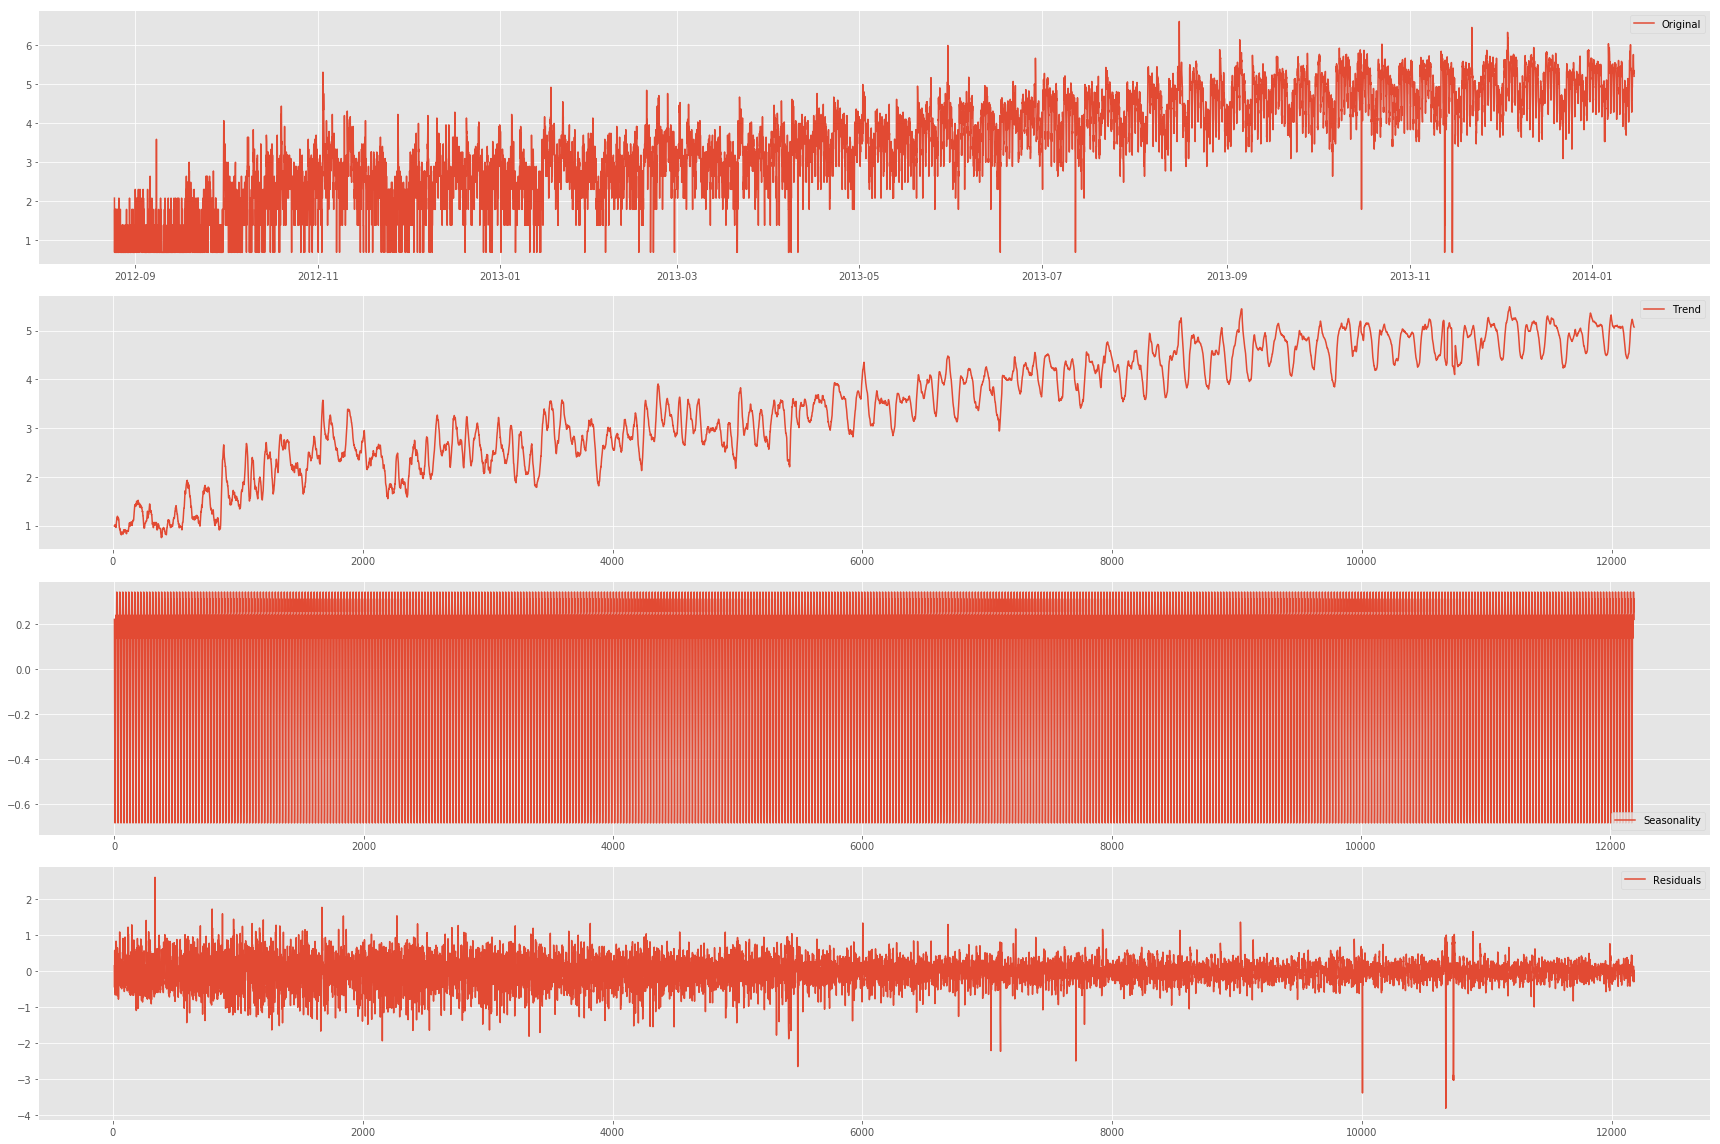

In [71]:
plt.figure(figsize=(24,16))
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(pd.DataFrame(train_log).Count.values, freq = 24)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(train_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

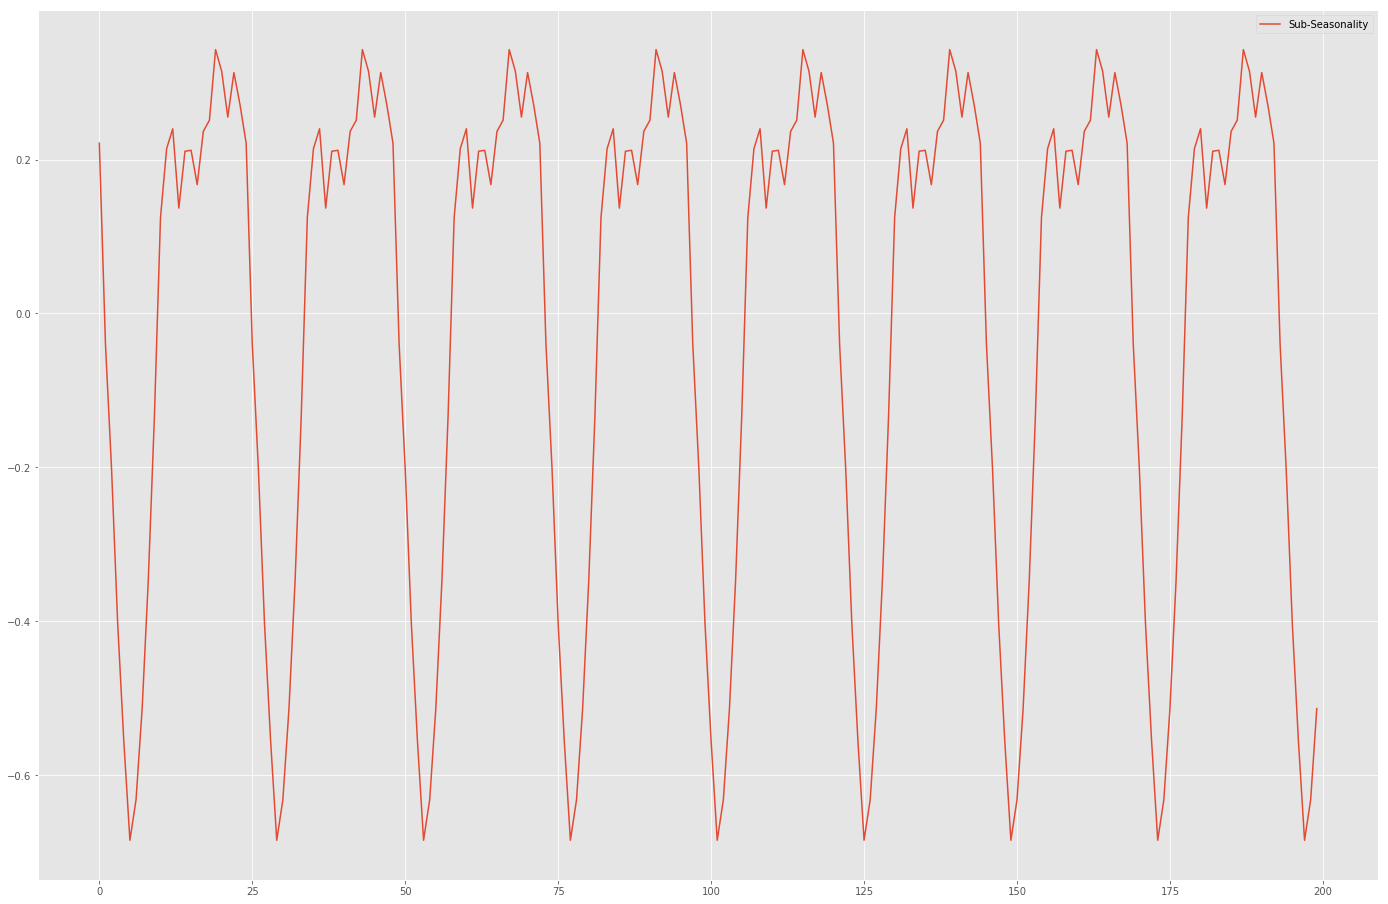

In [73]:
plt.figure(figsize=(24,16))
#A closer look at the seasonality 
plt.plot(seasonal[:200],label='Sub-Seasonality')
plt.legend(loc='best')

Here we can see that the trend, seasonality are separated out from data and we can model the residuals. The trend line show a gradual increasing trend, while the seasonality show a constant trend in counter. Lets check stationarity of residuals, which should have no pattern and normally distributed:

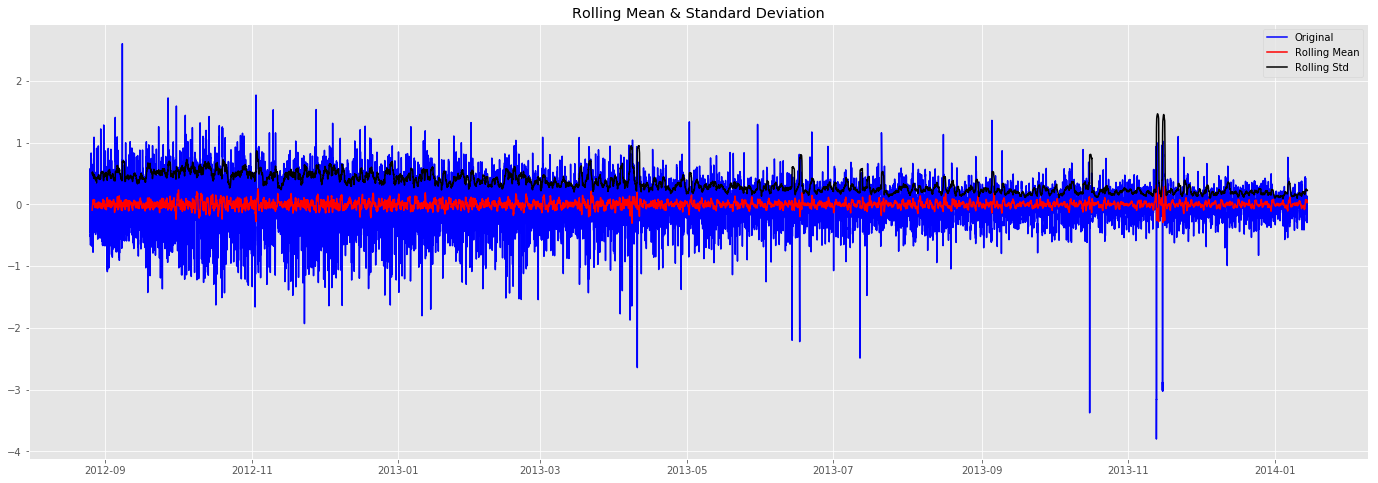

Results of Dickey-Fuller Test:
Test Statistic                   -28.600884
p-value                            0.000000
#Lags Used                        39.000000
Number of Observations Used    12129.000000
Critical Value (1%)               -3.430889
Critical Value (5%)               -2.861778
Critical Value (10%)              -2.566897
dtype: float64


In [75]:
plt.figure(figsize=(24,8))
train_log_decompose = pd.DataFrame(residual)
train_log_decompose['date'] = train_log.index
train_log_decompose.set_index('date', inplace = True)
train_log_decompose.dropna(inplace=True)
test_stationarity(train_log_decompose[0])

# Forecast a Time Series


To fit and predict a time series, we use ARIMA, which stands for auto-regressive integrated moving average and is specified by these three order parameters: (p, d, q).


* Auto regressive (AR(p)): referring to the use of past values in the regression equation for the series Y. p specifies the number of lags used in the model. For instance if p is 2, the predictors for x(t) will be x(t-1)x(t-2). AR(2) or, equivalently, ARIMA(2,0,0), is represented as
$$Y_t = c + \phi_1y_{t-1} + \phi_2 y_{t-2}+ e_t$$
where φ1, φ2 are parameters for the model.

* Moving average (MA(q)): representing the error of the model as a combination of previous error terms et. q determines the number of terms to include in the model. For instance if q is 5, the predictors for x(t) will be e(t-1)….e(t-5) where e(i) is the difference between the moving average at ith instant and actual value.
$$Y_t = c + \theta_1 e_{t-1} + \theta_2 e_{t-2} +...+ \theta_q e_{t-q}+ e_t$$
d represents the degree of differencing in the integrated (I(d)) component. For example, when d = 1 and d = 2:
$$Y_{d_t} = Y_t - Y_{t-1}$$$$Y_{d2_t} = Y_{d_t} - Y_{d_t-1} = (Y_t - Y_{t-1}) - (Y_{t-1} - Y_{t-2})$$
Differencing, autoregressive, and moving average components make up a non-seasonal ARIMA model which can be written as a linear equation:

$$ Y_t = c + \phi_1y_d{_{t-1}} +...+ \phi_p y_d{_{t-p}}+\theta_1 e_{t-1} +... + \theta_q e_{t-q} + e_t$$
where yd is Y differenced d times and c is a constant.

* Note that the model above assumes non-seasonal series, which means you might need to de-seasonalize the series before modeling. ARIMA methodology does have its limitations. These models directly rely on past values, and therefore work best on long and stable series. Also note that ARIMA simply approximates historical patterns and therefore does not aim to explain the structure of the underlying data mechanism.

An importance concern here is how to determine the value of ‘p’ and ‘q’. We use two plots to determine these numbers. Lets discuss them first.

* Autocorrelation Function (ACF): It is a measure of the correlation between the the TS with a lagged version of itself. For instance at lag 5, ACF would compare series at time instant ‘t1’…’t2’ with series at instant ‘t1-5’…’t2-5’ (t1-5 and t2 being end points).

* Partial Autocorrelation Function (PACF): This measures the correlation between the TS with a lagged version of itself but after eliminating the variations already explained by the intervening comparisons. Eg at lag 5, it will check the correlation but remove the effects already explained by lags 1 to 4.

https://people.duke.edu/~rnau/411arim3.htm

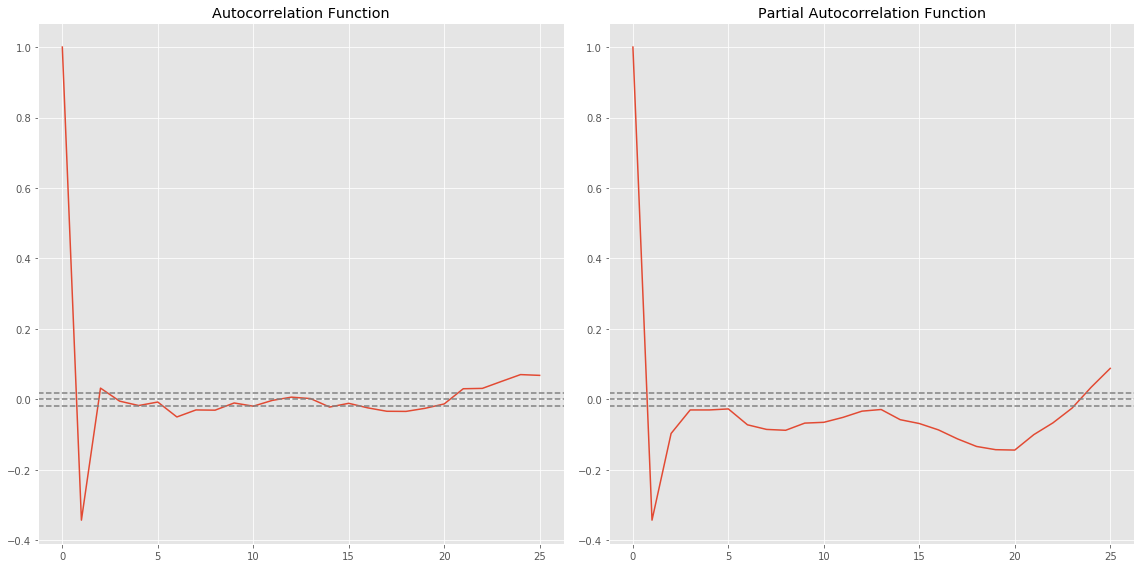

In [78]:
plt.figure(figsize=(16,8))
#ACF and PACF plots:
from statsmodels.tsa.stattools import acf, pacf
lag_acf = acf(train_log_diff.dropna(), nlags=25)
lag_pacf = pacf(train_log_diff.dropna(), nlags=25, method='ols')
#Plot ACF: 
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(train_log_diff.dropna())),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(train_log_diff.dropna())),linestyle='--',color='gray')
plt.title('Autocorrelation Function')
#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(train_log_diff.dropna())),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(train_log_diff.dropna())),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

In [79]:
train_log_diff.head()

Datetime
2012-08-25 00:00:00         NaN
2012-08-25 01:00:00   -1.386294
2012-08-25 02:00:00    1.098612
2012-08-25 03:00:00   -1.098612
2012-08-25 04:00:00    0.000000
Name: Count, dtype: float64


In this plot, the two dotted lines on either sides of 0 are the confidence interevals. These can be used to determine the ‘p’ and ‘q’ values as:

p – The lag value where the PACF chart crosses the upper confidence interval for the first time. If you notice closely, in this case p=1. And we also can see there is a spike at p = 1

q – The lag value where the ACF chart crosses the upper confidence interval for the first time. If you notice closely, in this case q=1. And we can also see there is a spike at q =1 .

In [80]:
from statsmodels.tsa.arima_model import ARIMA


The p,d,q values can be specified using the order argument of ARIMA which take a tuple (p,d,q). Let model the 3 cases: AR model, MA model and the combined model. Here, RSS stands for residual sum of squares. A small RSS indicates a tight fit of the model to the data. It is used as an optimality criterion in parameter selection and model selection.

## AR Model

C:\Users\ASUS\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
C:\Users\ASUS\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:191: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  start=index[0], end=index[-1], freq=freq)
C:\Users\ASUS\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


Text(0.5,1,'RSS: nan')

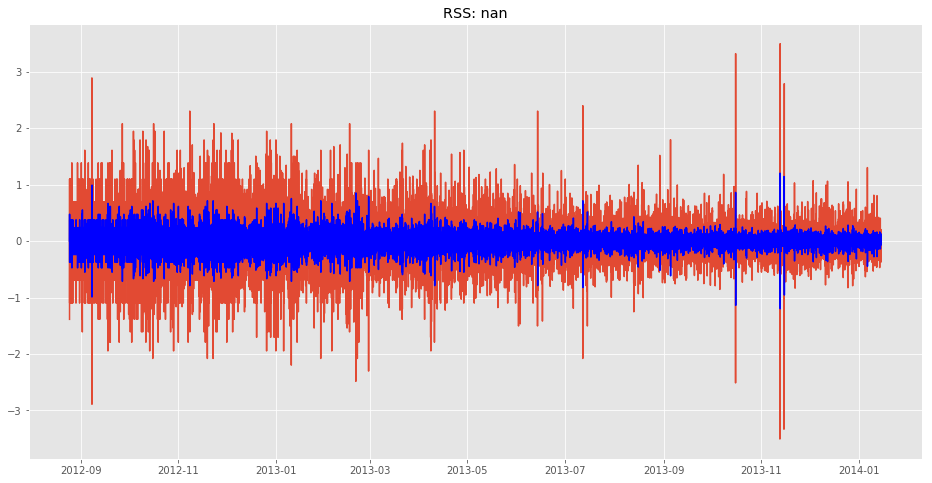

In [82]:
plt.figure(figsize=(16,8))
model = ARIMA(train_log, order=(1, 1, 0))  
results_AR = model.fit(disp=-1)  
plt.plot(train_log_diff.dropna())
plt.plot(results_AR.fittedvalues, color='blue')
plt.title('RSS: %.4f'% sum((results_AR.fittedvalues-train_log_diff)**2))

## MA model

C:\Users\ASUS\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
C:\Users\ASUS\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:191: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  start=index[0], end=index[-1], freq=freq)
C:\Users\ASUS\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


Text(0.5,1,'RSS: nan')

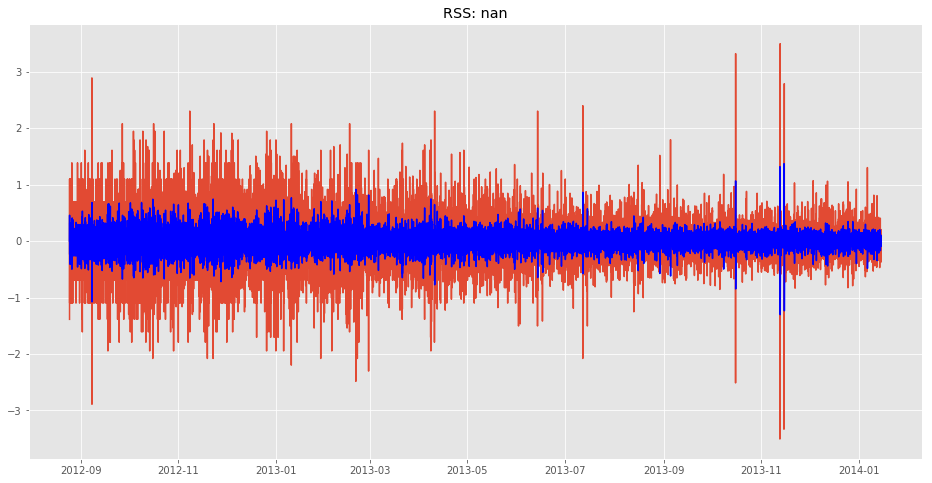

In [85]:
plt.figure(figsize=(16,8))
model = ARIMA(train_log, order=(0, 1, 1))  
results_ARIMA = model.fit(disp=-1)  
plt.plot(train_log_diff.dropna())
plt.plot(results_ARIMA.fittedvalues, color='blue')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-train_log_diff)**2))

## Combined model

C:\Users\ASUS\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
C:\Users\ASUS\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:191: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  start=index[0], end=index[-1], freq=freq)
C:\Users\ASUS\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


Text(0.5,1,'RSS: nan')

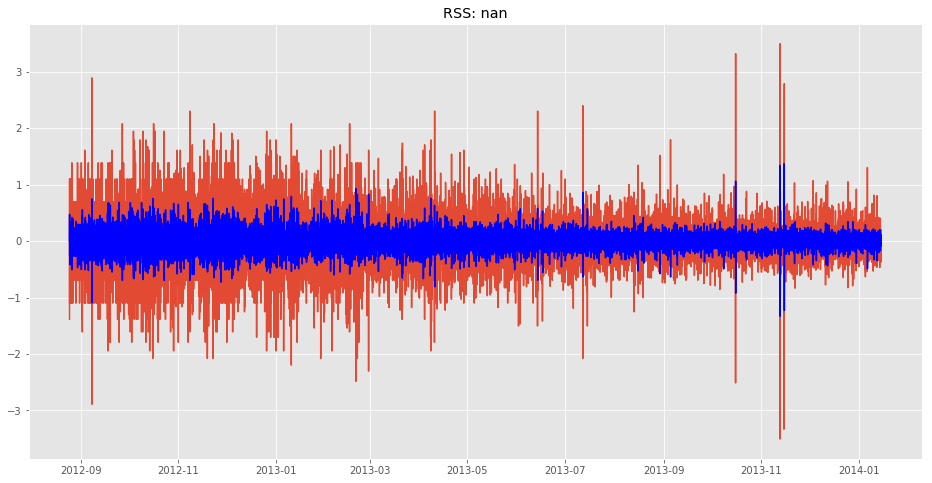

In [86]:
plt.figure(figsize=(16,8))
model = ARIMA(train_log, order=(1, 1, 1))  
results_MA = model.fit(disp=-1)  
plt.plot(train_log_diff.dropna())
plt.plot(results_MA.fittedvalues, color='blue')
plt.title('RSS: %.4f'% sum((results_MA.fittedvalues-train_log_diff)**2))


# Taking it back to the original scale

Lets scale it back to the original values and see how well it performs there. First step would be to store the predicted results as a separate series and observe it.

In [92]:

#bring the differencing back to the original scale
def check_prediction_diff(predict_diff, given_set):
    predict_diff= predict_diff.cumsum().shift().fillna(0)
    predict_base = pd.Series(np.ones(given_set.shape[0]) * np.log(given_set['Count'])[0], index = given_set.index)
    predict_log = predict_base.add(predict_diff,fill_value=0)
    predict = np.exp(predict_log)
    
    plt.figure(figsize=(16,8))
    plt.plot(given_set['Count'], label = "Given set")
    plt.plot(predict, color = 'blue', label = "Predict")
    plt.legend(loc= 'best')
    plt.title('RMSE: %.4f'% (np.sqrt(np.dot(predict, given_set['Count']))/given_set.shape[0]))

In [97]:
def check_prediction_log(predict_log, given_set):
    predict = np.exp(predict_log)
    plt.figure(figsize=(16,8))
    plt.plot(given_set['Count'], label = "Given set")
    plt.plot(predict, color = 'blue', label = "Predict")
    plt.legend(loc= 'best')
    plt.title('RMSE: %.4f'% (np.sqrt(np.dot(predict, given_set['Count']))/given_set.shape[0]))

In [89]:
# Tried on MA model 
model = ARIMA(train_log.dropna(), order=(0, 1, 1))  
results_ARIMA = model.fit(disp=-1)  
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
print (predictions_ARIMA_diff.head())

Datetime
2012-08-25 01:00:00    0.000294
2012-08-25 02:00:00    0.457377
2012-08-25 03:00:00   -0.236857
2012-08-25 04:00:00    0.323809
2012-08-25 05:00:00    0.122112
dtype: float64


C:\Users\ASUS\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
C:\Users\ASUS\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:191: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  start=index[0], end=index[-1], freq=freq)
C:\Users\ASUS\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


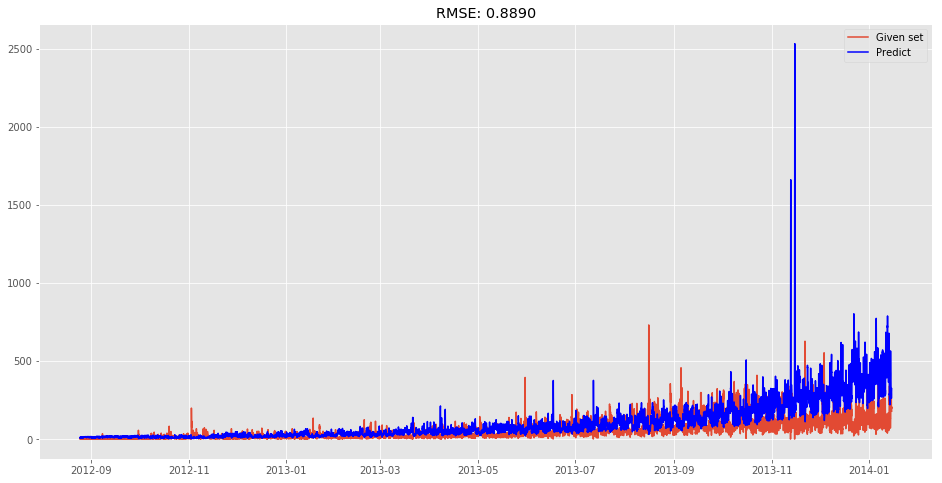

In [93]:
check_prediction_diff(predictions_ARIMA_diff, train)

# Predict on the valid set

In [94]:
start = train.shape[0]
end = start + valid.shape[0]
valid_predict_diff = results_ARIMA.predict(start = start-1, end = end-2, typ = 'levels')
print (valid_predict_diff.head())
print (valid_predict_diff.tail())

2014-01-15 00:00:00    5.321110
2014-01-15 01:00:00    5.241479
2014-01-15 02:00:00    5.241773
2014-01-15 03:00:00    5.242067
2014-01-15 04:00:00    5.242362
Freq: H, dtype: float64
2014-09-25 19:00:00    7.032839
2014-09-25 20:00:00    7.033133
2014-09-25 21:00:00    7.033427
2014-09-25 22:00:00    7.033722
2014-09-25 23:00:00    7.034016
Freq: H, dtype: float64


C:\Users\ASUS\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:320: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  freq=base_index.freq)


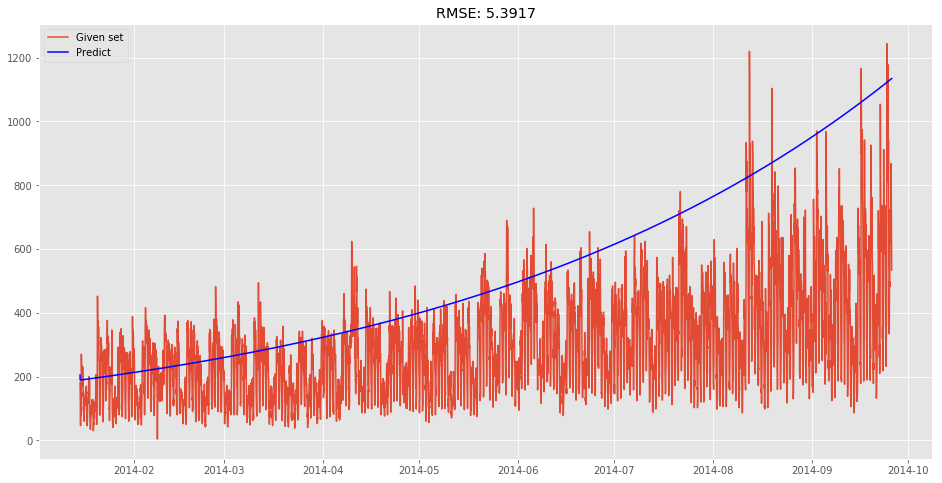

In [98]:
check_prediction_log(valid_predict_diff, valid)